# Testing Trained model outputs
> Created November 2025 <br>
> Nikhil Bisht<br>

# Definitions

In [19]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp
import skimage as ski

# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision

from torchvision.utils import save_image
from model1_0 import *
from all_modules import *

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
DATASETNAME = '/anvil/scratch/x-nbisht1/projects/512/NonsinkSimSuite/training_copy.hdf5'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 64
FRAME_DIFF = 33
TEST_PERCENTAGE = 0.001

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}', flush=True)

def model_performance(pred_output_arr, act_output_arr):
    # Calculate metrics
    if pred_output_arr.shape[2]>1:
        pred_MSE = []
        for i in range(pred_output_arr.shape[2]):
            pred_MSE.append(ski.metrics.mean_squared_error(act_output_arr[0][-1][i], pred_output_arr[0][-1][i]))
            if i==0:
                inversed_pred_output_arr = img_inverse_transform(pred_output_arr[0][-1][i])
                inversed_act_output_arr = img_inverse_transform(act_output_arr[0][-1][i])

                pred_total_density = np.sum(inversed_pred_output_arr)
                act_total_density = np.sum(inversed_act_output_arr)
                density_difference = np.abs(pred_total_density - act_total_density)
    else:
        pred_MSE = ski.metrics.mean_squared_error(act_output_arr, pred_output_arr)
        inversed_pred_output_arr = img_inverse_transform(pred_output_arr)
        inversed_act_output_arr = img_inverse_transform(act_output_arr)

        pred_total_density = np.sum(inversed_pred_output_arr)
        act_total_density = np.sum(inversed_act_output_arr)
        density_difference = np.abs(pred_total_density - act_total_density)

    return pred_MSE, density_difference

def plot_comparison(input_arr, pred_output_arr, act_output_arr, label):
    input_str = 'INPUT IMAGE:\n'
    pred_str = 'PREDICTED IMAGE:\n'
    act_str = 'ACTUAL IMAGE:\n'
    # Calculate metrics
    input_MSE = ski.metrics.mean_squared_error(act_output_arr, input_arr)
    input_str+= 'MSE: '+'{:0.5f}'.format(input_MSE)+'\n'
    pred_MSE = ski.metrics.mean_squared_error(act_output_arr, pred_output_arr)
    pred_str+= 'MSE: '+'{:0.5f}'.format(pred_MSE)+'\n'
    actual_MSE = ski.metrics.mean_squared_error(act_output_arr, act_output_arr)
    act_str+= 'MSE: '+'{:0.5f}'.format(actual_MSE)+'\n'

    input_NMI = ski.metrics.normalized_mutual_information(act_output_arr, input_arr, bins=100)
    input_str+= 'NMI: '+'{:0.5f}'.format(input_NMI)+'\n'
    pred_NMI = ski.metrics.normalized_mutual_information(act_output_arr, pred_output_arr, bins=100)
    pred_str+= 'NMI: '+'{:0.5f}'.format(pred_NMI)+'\n'
    actual_NMI = ski.metrics.normalized_mutual_information(act_output_arr, act_output_arr, bins=100)
    act_str+= 'NMI: '+'{:0.5f}'.format(actual_NMI)+'\n'

    inversed_input_arr = img_inverse_transform(input_arr)
    inversed_pred_output_arr = img_inverse_transform(pred_output_arr)
    inversed_act_output_arr = img_inverse_transform(act_output_arr)
    input_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_input_arr, data_range=np.max(inversed_input_arr) - np.min(inversed_input_arr))
    input_str+= 'PSNR: '+'{:0.5f}'.format(input_PSNR)+'\n'
    pred_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_pred_output_arr, data_range=np.max(inversed_pred_output_arr) - np.min(inversed_pred_output_arr))
    pred_str+= 'PSNR: '+'{:0.5f}'.format(pred_PSNR)+'\n'
    actual_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_act_output_arr, data_range=np.max(inversed_act_output_arr) - np.min(inversed_act_output_arr))
    act_str+= 'PSNR: '+'{:0.5f}'.format(actual_PSNR)+'\n'

    input_SSI = ski.metrics.structural_similarity(act_output_arr, input_arr, gradient=False, data_range=np.max(input_arr) - np.min(input_arr), channel_axis=None)
    input_str+= 'SSI: '+'{:0.5f}'.format(input_SSI)+'\n'
    pred_SSI = ski.metrics.structural_similarity(act_output_arr, pred_output_arr, gradient=False, data_range=np.max(pred_output_arr) - np.min(pred_output_arr), channel_axis=None)
    pred_str+= 'SSI: '+'{:0.5f}'.format(pred_SSI)+'\n'
    actual_SSI = ski.metrics.structural_similarity(act_output_arr, act_output_arr, gradient=False, data_range=np.max(act_output_arr) - np.min(act_output_arr), channel_axis=None)
    act_str+= 'SSI: '+'{:0.5f}'.format(actual_SSI)+'\n'

    input_total_density = np.sum(inversed_input_arr)
    input_str+= 'Total Density: '+'{:0.5f}'.format(input_total_density)+'\n'
    pred_total_density = np.sum(inversed_pred_output_arr)
    pred_str+= 'Total Density: '+'{:0.5f}'.format(pred_total_density)+'\n'
    act_total_density = np.sum(inversed_act_output_arr)
    act_str+= 'Total Density: '+'{:0.5f}'.format(act_total_density)+'\n'

    input_FFTL = F.mse_loss(torch.log1p(torch.abs(torch.fft.fftn(torch.from_numpy(input_arr)))), torch.log1p(torch.abs(torch.fft.fftn(torch.from_numpy(act_output_arr)))))
    input_str+= 'FFTL: '+'{:0.5f}'.format(input_FFTL)+'\n'
    pred_FFTL = F.mse_loss(torch.log1p(torch.abs(torch.fft.fftn(torch.from_numpy(pred_output_arr)))), torch.log1p(torch.abs(torch.fft.fftn(torch.from_numpy(act_output_arr)))))
    pred_str+= 'FFTL: '+'{:0.5f}'.format(pred_FFTL)+'\n'
    actual_FFTL = F.mse_loss(torch.log1p(torch.abs(torch.fft.fftn(torch.from_numpy(act_output_arr)))), torch.log1p(torch.abs(torch.fft.fftn(torch.from_numpy(act_output_arr)))))
    act_str+= 'FFTL: '+'{:0.5f}'.format(actual_FFTL)+'\n'

    fig = plt.figure(figsize=(12, 12))
    
    for i in range(3):
        ax  = fig.add_subplot(3, 3, 3*i+1)
        c = ax.pcolormesh(np.mean(input_arr, axis=i).T, vmin=-1, vmax=1, cmap='gnuplot2')
        fig.colorbar(c, ax=ax)
        if i==0:
            ax.set_title('Input: '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax.grid('both')
        if i==2:
            ax.text(0.15, -0.02, input_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax2  = fig.add_subplot(3, 3, 3*i+2)
        c = ax2.pcolormesh(np.mean(pred_output_arr, axis=i).T, vmin=-1, vmax=1, cmap='gnuplot2')
        fig.colorbar(c, ax=ax2)
        if i==0:
            ax2.set_title('Predicted Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax2.grid('both')
        if i==2:
            ax2.text(0.4, -0.02, pred_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax3  = fig.add_subplot(3, 3, 3*i+3)
        c = ax3.pcolormesh(np.mean(act_output_arr, axis=i).T, vmin=-1, vmax=1, cmap='gnuplot2')
        fig.colorbar(c, ax=ax3)
        if i==0:
            ax3.set_title('Actual Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax3.grid('both')
        if i==2:
            ax3.text(0.7, -0.02, act_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    
    plt.show()
    plt.close()



def compare_output_batch(dataset, args, argsGRU, batch_size=1, num_workers=0):
    """
    Compare model predictions with ground truth using batch processing.
    More efficient for large datasets.
    
    Parameters:
    -----------
    dataset : torch.utils.data.Dataset
        Dataset containing input/output pairs
    args : object
        Arguments object containing model configuration
    argsGRU : object
        GRU-specific arguments
    batch_size : int
        Batch size for processing (default: 1 for individual image saving)
    num_workers : int
        Number of DataLoader workers
    
    Returns:
    --------
    tuple : (mean_MSE, mean_density_difference)
    """
    from torch.utils.data import DataLoader
    
    # Create DataLoader
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False,  # Keep original order
        num_workers=num_workers,
        pin_memory=True
    )
    
    # Load the trained model
    model = modelclass(args, argsGRU).to(DEVICE, non_blocking=True)
    checkpoint = torch.load(f"./models/{args.run_name}_{MODELFILE}", map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded with {count_parameters(model):,} trainable parameters.", flush=True)
    
    # Set the model to evaluation mode
    model.eval()
    pred_MSEs = []
    density_differences = []
    is_m = 0
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(loader):
            # Unpack batch data
            input_batch, output_batch, label_batch = batch_data
            
            # Format for model input
            if args.in_channel == 1:
                inputs = input_batch.unsqueeze(2)  # Add channel dimension
                targets = output_batch.unsqueeze(1)  # Add channel dimension
            else:
                inputs, targets = input_batch, output_batch
            
            # Move to device
            inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)
            
            # Get model predictions
            outputs = model(inputs)
            
            # Process each item in the batch
            for i in range(inputs.size(0)):
                # Extract single sample
                single_input = inputs[i:i+1]
                single_output = outputs[i:i+1]
                single_target = targets[i:i+1]
                single_label = [label_batch[0][i].item(), label_batch[1][i], label_batch[2][i].item()]
                
                # Convert to numpy
                output_np = single_output.cpu().numpy()
                target_np = single_target.cpu().numpy()
                input_np = single_input.cpu().numpy()
                
                # Calculate performance metrics
                pred_MSE, density_difference = model_performance(output_np, target_np)
                print(output_np.shape, target_np.shape, input_np.shape)
                
                # Create comparison plot
                sample_idx = batch_idx * batch_size + i
                if sample_idx%10 == 0:  # Save every 10th sample
                    if output_np.shape[2]>1:
                        is_m = 1
                        for ch in range(output_np.shape[2]):
                            plot_comparison(
                                input_np[0][-1][ch],  # Last frame of input sequence
                                output_np[0][-1][ch], 
                                target_np[0][-1][ch], 
                                single_label, 
                            )
                    else:
                        plot_comparison(
                            input_np[0][-1][0],  # Last frame of input sequence
                            output_np[0][-1][0], 
                            target_np[0][1][0], 
                            single_label,
                        )
                
                pred_MSEs.append(pred_MSE)
                density_differences.append(density_difference)
    
    if is_m==1:
        return np.mean(pred_MSEs,axis=0), np.mean(density_differences)
    else:
        return np.mean(pred_MSEs), np.mean(density_differences)


def recursive_model_prediction_eval(modelclass, simname, args, argsGRU, num_of_cycles=3, delta_t=33):
    """
    Recursively go from Initial state to final outpurt and compare the two"""
    # Load the trained model
    model = modelclass(args, argsGRU).to(DEVICE, non_blocking=True)
    checkpoint = torch.load(f"./models/{args.run_name}_{MODELFILE}", map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded with {count_parameters(model):,} trainable parameters.", flush=True)
    
    # Set the model to evaluation mode
    model.eval()
    output_dir = './models/plots/test/output_'+argsUNET.run_name
    predictions = []
    #Open raw npy timecubes of the simname and get initial and final frame
    TSCube_D, TSCube_Vx, TSCube_Vy, TSCube_Vz = [], [], [], []
    for CUBES in ['density', 'x-velocity', 'y-velocity', 'z-velocity']:
        infile = open(timecube_basepath+simname+'_TimeseriesCubes_'+CUBES+'.npy', 'rb')
        TSCube = np.load(infile)
        time_array = np.load(infile)
        infile.close()
        dsample = nn.AvgPool3d(2)
        print(CUBES+' opened')
        print("Cube original shape:",TSCube.shape)
        TSCube = dsample(torch.from_numpy(TSCube).unsqueeze(1)) #64
        TSCube = TSCube.squeeze(1).numpy()
        print("Cube reshaping:",TSCube.shape)
        if CUBES == 'density':
            TSCube_D = TSCube
        elif CUBES == 'x-velocity':
            TSCube_Vx = TSCube
        elif CUBES == 'y-velocity':
            TSCube_Vy = TSCube
        elif CUBES == 'z-velocity':
            TSCube_Vz = TSCube
            H_initial = []
    sequence_len = 2
    frame = 0 #Initial is the IC of the simulation
    H_initial = []
    H_final = []
    for seq in range(sequence_len):
        H_seq_D = img_transform(TSCube_D[frame+seq])
        H_seq_Vx = TSCube_Vx[frame+seq]
        H_seq_Vy = TSCube_Vy[frame+seq]
        H_seq_Vz = TSCube_Vz[frame+seq]
        H_seq = np.stack((H_seq_D, H_seq_Vx, H_seq_Vy, H_seq_Vz), axis=0)
        H_initial.append(H_seq)
        H_final_D = img_transform(TSCube_D[frame+seq-1+num_of_cycles*delta_t])
        H_final_Vx = TSCube_Vx[frame+seq-1+num_of_cycles*delta_t]
        H_final_Vy = TSCube_Vy[frame+seq-1+num_of_cycles*delta_t]
        H_final_Vz = TSCube_Vz[frame+seq-1+num_of_cycles*delta_t]
        H_final_seq = np.stack((H_final_D, H_final_Vx, H_final_Vy, H_final_Vz), axis=0)
        H_final.append(H_final_seq)
    H_initial = np.array(H_initial)
    H_final = np.array(H_final)
    print("Initial Array shape:",H_initial.shape)
    print("Final Array shape:",H_final.shape)
    #Convert to torch tensors and move to device
    H_initial_tensor = torch.from_numpy(H_initial).unsqueeze(0).to(DEVICE)
    H_final_tensor = torch.from_numpy(H_final).unsqueeze(0).to(DEVICE)
    rec_label = (frame,'xy',0, simname)
    with torch.no_grad():
        current_input = H_initial_tensor
        for cycle in range(num_of_cycles):
            output = model(current_input)
            print("Cycle:",cycle+1," Output shape:",output.shape)
            predictions.append(output.cpu().numpy())
            #Prepare input for next cycle
            current_input = output
    print("Prediction shape:",predictions[-1].shape)
    for ch in range(H_final_tensor.shape[2]):
        plot_comparison(
            H_initial_tensor[0][-1][ch].numpy(),  # Last frame of input sequence
            predictions[-1][0][-1][ch], 
            H_final_tensor[0][-1][ch].numpy(), 
            rec_label, 
        )
    pred_MSEs, density_differences = model_performance(predictions[-1], H_final_tensor.cpu().numpy())
    print(f"Recursive Prediction after {num_of_cycles} cycles - MSE: {pred_MSEs}, Density Difference: {density_differences}", flush=True)


Available device: cpu 


In [15]:
import time

# Prepare datasets
start = time.time()
print('Preparing HDF5 datasets!', flush=True)
number_of_samples = 2000
train_dataset, test_dataset, train_indices, test_indices = load_hdf5_data_for_training(DATASETNAME, num_samples=number_of_samples,test_percentage=TEST_PERCENTAGE,seed=seed)
end = time.time()
print(f"Time taken to load image hdf5: {end - start:.2f} seconds", flush=True)


Preparing HDF5 datasets!
Total samples in HDF5 file: 4221
Training samples: 1998, Test samples: 2
Time taken to load image hdf5: 0.06 seconds


Model loaded with 2,157,435 trainable parameters.
density opened
Cube original shape: (100, 128, 128, 128)
Cube reshaping: (100, 64, 64, 64)
x-velocity opened
Cube original shape: (100, 128, 128, 128)
Cube reshaping: (100, 64, 64, 64)
y-velocity opened
Cube original shape: (100, 128, 128, 128)
Cube reshaping: (100, 64, 64, 64)
z-velocity opened
Cube original shape: (100, 128, 128, 128)
Cube reshaping: (100, 64, 64, 64)
Initial Array shape: (2, 4, 64, 64, 64)
Final Array shape: (2, 4, 64, 64, 64)
Cycle: 1  Output shape: torch.Size([1, 2, 4, 64, 64, 64])
Cycle: 2  Output shape: torch.Size([1, 2, 4, 64, 64, 64])
Cycle: 3  Output shape: torch.Size([1, 2, 4, 64, 64, 64])
Prediction shape: (1, 2, 4, 64, 64, 64)


/home/x-nbisht1/nbisht_06032025/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


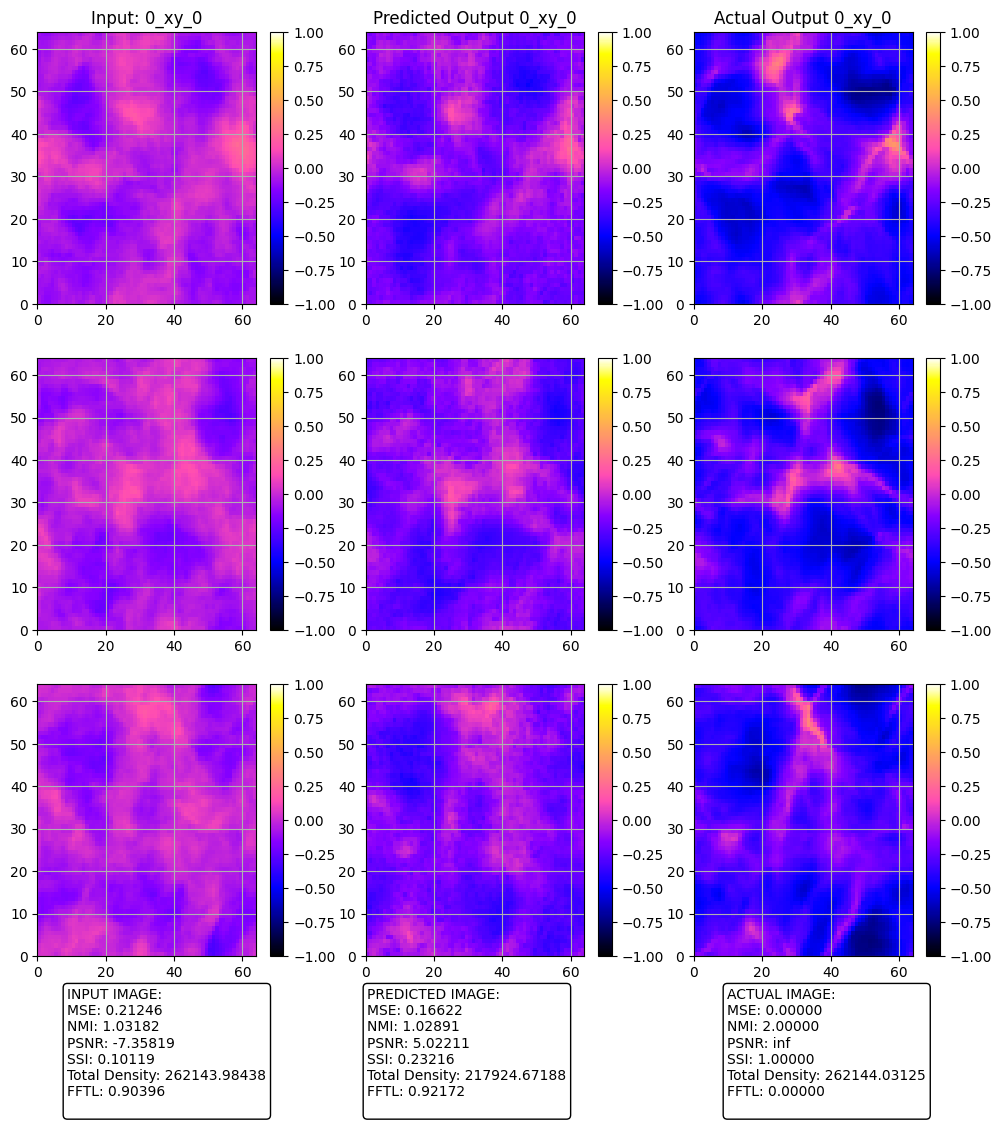

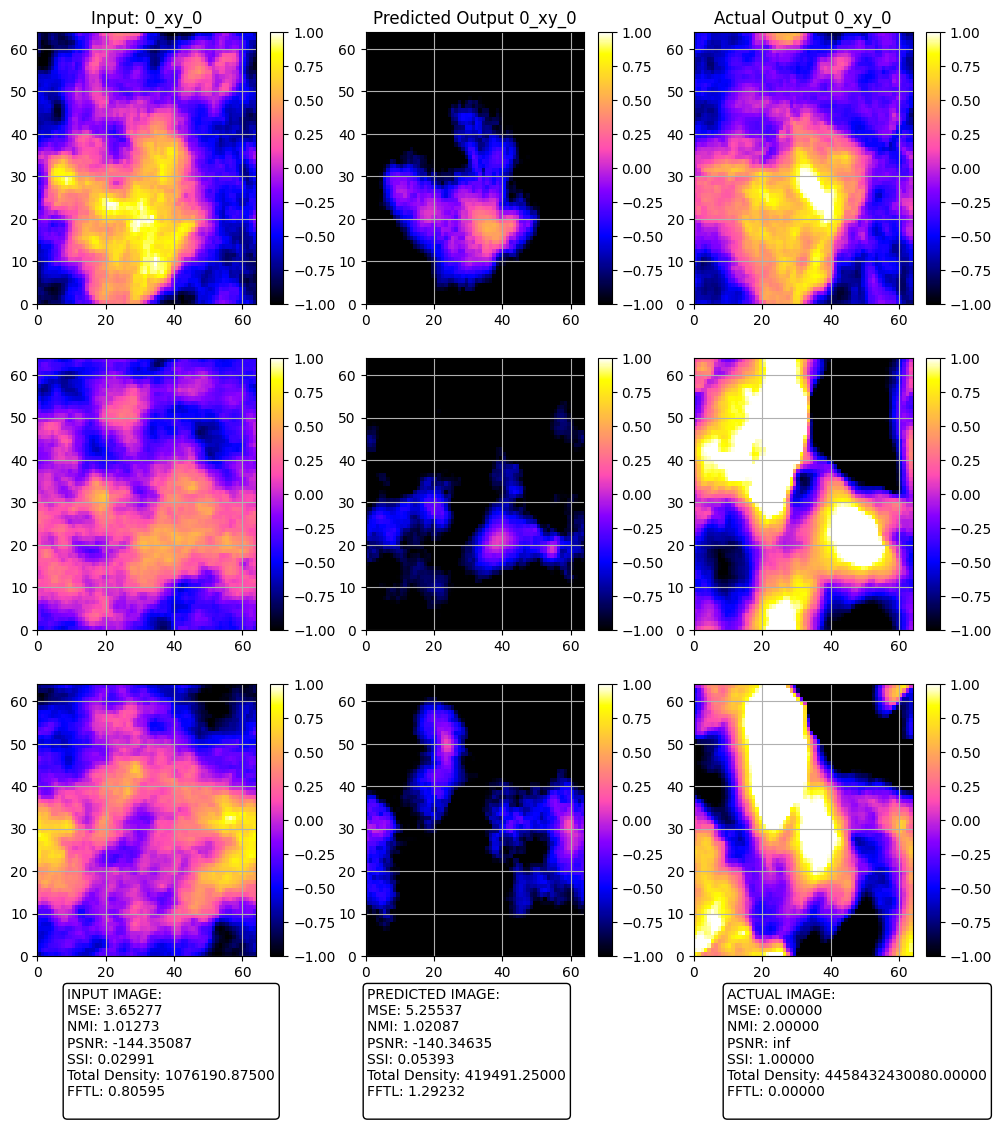

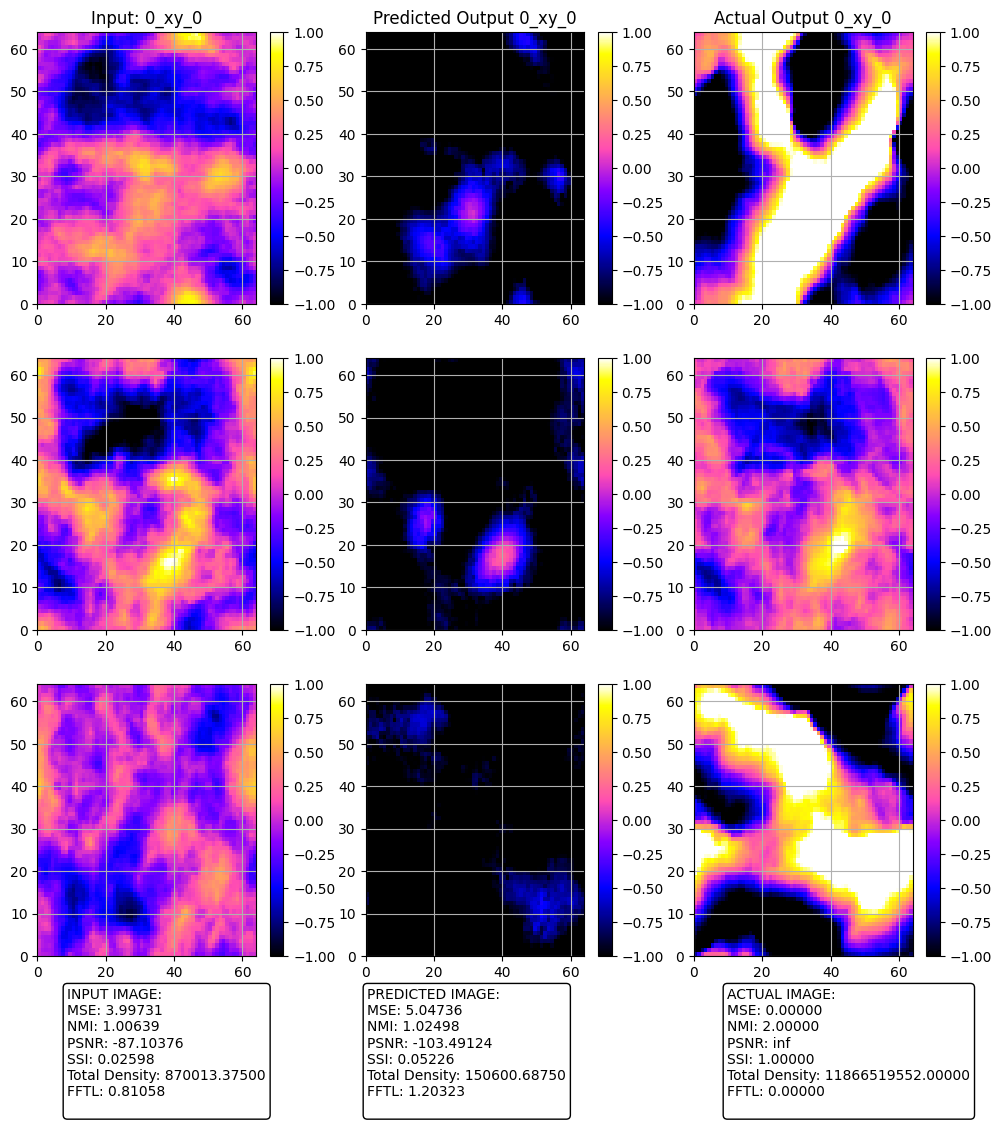

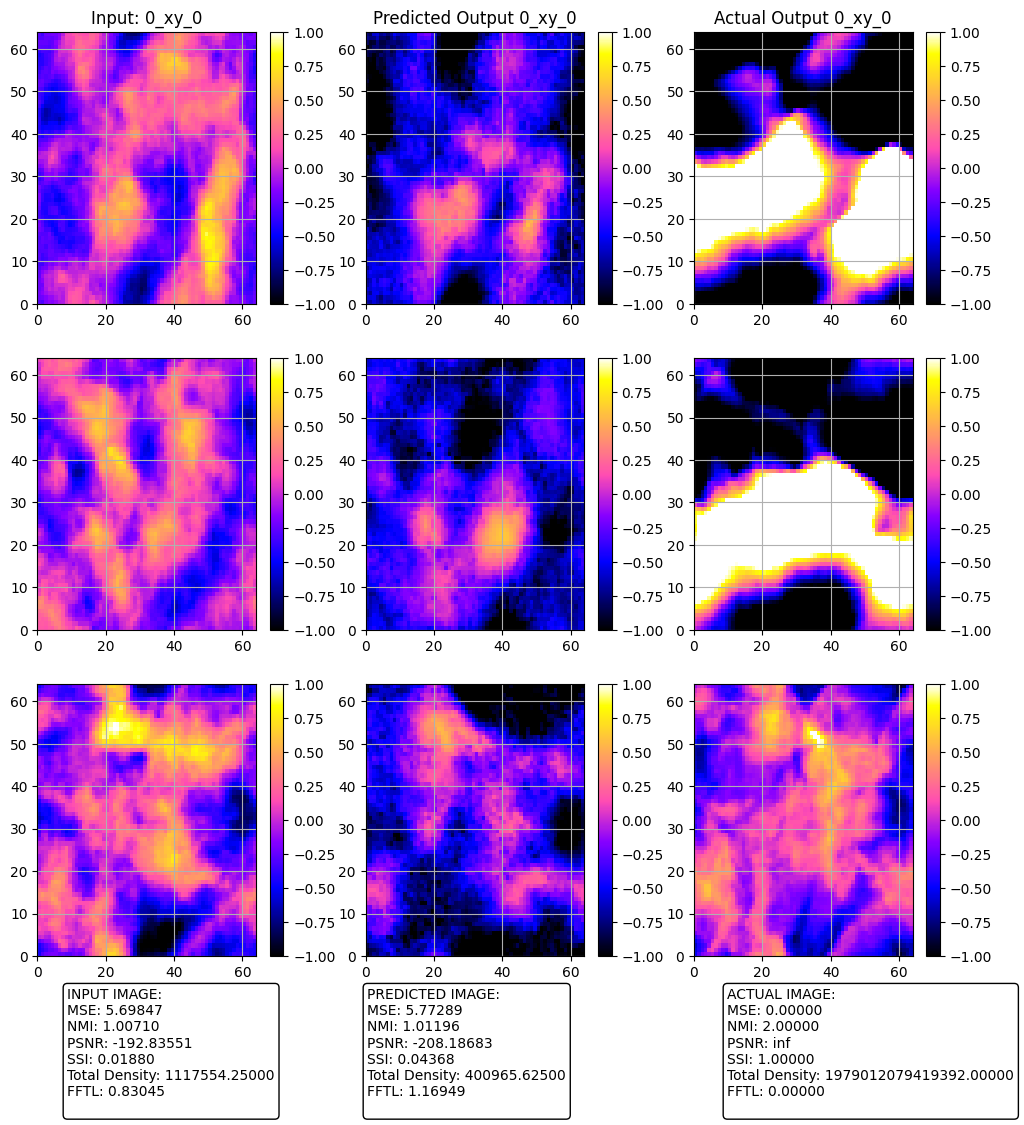

Recursive Prediction after 3 cycles - MSE: [0.1662220061716312, 5.255366769157024, 5.047355087525072, 5.7728942599002195], Density Difference: 44219.359375


In [20]:
# Setup arguments
parser = argparse.ArgumentParser()
argsUNET = parser.parse_args(args=[])
argsUNET.image_size = IMAGESIZE
argsUNET.device = 'cuda' if torch.cuda.is_available() else 'cpu'
argsUNET.run_name = "model1_0_convGRUnet_nonsink_allfeatures_seq2_statistical_loss"
argsUNET.loss_type = 'statistical'
argsUNET.in_channel = 4
argsUNET.out_channel = 4
argsUNET.epochs = 100
argsUNET.lr = 3e-4
#for CPU run, keep to 8, GPU run, reduce to 2 with accumulation at 4
argsUNET.batch_size = 8  # Will be reduced automatically if OOM
argsUNET.accum_steps = 1
argsUNET.num_workers = 4
argsUNET.Adamw_weight_decay = 1e-4
argsUNET.DWA_temperature = 2
argsUNET.base_f = 32
argsUNET.depth = 3
argsUNET.attention_int_division = 2
argsUNET.conv_param = (3,1,1,1)  # kernel size, stride, padding, dilation
argsUNET.LRLU_slope = 0.01  # LeakyReLU slope, 0 for ReLU
argsUNET.dropout_rate = 0.2  # dropout rate, 0 for no dropout

argsGRU = parser.parse_args(args=[])
argsGRU.in_channel = 4
argsGRU.out_channel = 4
argsGRU.in_seq = 2
argsGRU.out_seq = 2
argsGRU.num_layers = 2
argsGRU.kernels = [3, 3]
argsGRU.hidden_dims = [32, 64]
argsGRU.bias = False
modelclass = hybridConvGRU3DNET


timecube_basepath = '/anvil/scratch/x-nbisht1/projects/512/NonsinkSimSuite/timecubes/'
rec_simname = 'd03_DD0090'
recursive_model_prediction_eval(modelclass, rec_simname, argsUNET, argsGRU, num_of_cycles=3, delta_t=33)